# NMT: Neural Machine Translation With Attention

In this notebook we will implement a RNN based sequence-to-sequence encoder-decoder architecture to translate one language to another using PyTorch. The model is from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) by D Bahdanau, K Cho, Y Bengio.
.

**We will:**
* Get the necessary data and try to represent a language
* Preprocess the data to create pairs of utterences and create dataset splits with tokenization
* Formulate the NMT task, and create, convert input-output pairs according to the task
* Implement the Encoder, Attention, Decoder models in PyTorch
* Combine these models to create Seq2Seq model its sequential forward pass.
* Implement the training loop, train the model
* Implement inference to translate at our will.
* Check attention map to understand relation between input and output sentence.
* Save and load the model

## Diagrams to understand NMT with Attention

___________
NMT task formulation

![nmt_task_formulation.drawio.png](nmt_task_formulation.drawio.png)

_______

General Encoder Decoder Model


![](nmt_task_formulation-general_encoder_decoder_model.drawio.png)
_____

First we import all the required modules.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import math
import time
import re
import random
from math import floor
from typing import Tuple, List, Optional
from torch.utils.data import Dataset, DataLoader, random_split

import torch
import torch.nn as nn
from torch import optim, Tensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from datasets import tqdm
import requests
import zipfile

In [2]:
%matplotlib inline

Setting our main device for computations

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Set the random seeds for reproducability.

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

 # Download Data

First, we download and extract the dataset we will be using.

In [5]:
def download_data(url, save_name="nmt_data.zip"):
    r = requests.get(url, stream=True)

    bar = tqdm(
        total=int(r.headers["Content-Length"]),
        initial=0,
        unit='B',
        unit_scale=True,
    )

    with open(save_name, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(1024)
    bar.close()

def extract_data(saved_name="nmt_data.zip"):
    zipfile.ZipFile(saved_name).extractall()

In [6]:
data_url = "https://download.pytorch.org/tutorial/data.zip"
download_data(data_url)

  0%|          | 0.00/2.88M [00:00<?, ?B/s]

In [7]:
extract_data()

 # Representing a language
When we check our data, we would see pairs of sentences in two languages. However, our models are not capable of directly interpreting words, otherwise we would have no problem at all :)

Instead we will first represent a word in a language with a specific index. There other ways to represent a language such as character level encoding but in this notebook, we are going to use word level encoding.

To do that we need to have 2 dictionaries word2index, given a word returns its index, and index2word, given an index returns its word.

Additionally, we are keeping track of word counts because we might also want replace less frequent with <unknown> token.

___________
![lang_representation.drawio.png](lang_representation.drawio.png)

In [8]:
sos_token_index = 1
eos_token_index = 2
pad_token_index = 0
sos_token = '<start>'
eos_token = '<end>'

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {sos_token:sos_token_index, eos_token: eos_token_index}
        self.word2count = {sos_token:1, eos_token: 1}
        self.index2word = {sos_token_index: sos_token, eos_token_index: eos_token}
        self.n_words = 3 # Count SOS and EOS

    def add_sentence(self, sentence: str):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word: str):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Before creating a language we need to preprocess the data!

In [9]:
def unicode_to_ascii(sentence: str) -> str:
    """
     NFD, 'Normal Form Decomposed' gives you decomposed, combined characters.
    Mn, Nonspacing mark
    :param sentence:
    :return: ascii sentence
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', sentence)
        if unicodedata.category(c) != 'Mn'
    )

Because the files are all in Unicode, we will convert Unicode characters to ASCII, lowercase everything, and remove most punctuation.

In [10]:
def normalize_string(s: str) -> str:
    s = unicode_to_ascii(s.lower().strip())
    # creating a space between a word and the punctuyouation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "¿")
    s = re.sub(r"[^a-zA-Z?.!,¿]+", " ", s)
    return s.strip()

In [11]:
sentences = [u"May I borrow this book?",
             u"¿Puedo tomar prestado este libro?",
             u"Puis-je emprunter ce livre?"]
for sentence in sentences:
    print(normalize_string(sentence).encode('utf-8'))

b'may i borrow this book ?'
b'\xc2\xbf puedo tomar prestado este libro ?'
b'puis je emprunter ce livre ?'


# Dataset creation and tokenization

To read the data file, we will divide it into lines and then into pairs. Also, we need to be sure that we are normalizing every expression in each language.

In [12]:
def read_langs(lang1: str, lang2: str, num_examples: Optional[int] = None) -> (Lang, Lang, List[Tuple[str]]):
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8')\
        .read()\
        .strip()\
        .split('\n')
    if num_examples:
        lines=lines[:num_examples]
    print('Read %s lines' % len(lines))
    pairs = [[normalize_string(s) for s in l.split('\t')[:2]] for l in lines]
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

We'll limit the dataset to only very short and easy sentences because there are a lot of sample sentences and we want to train something very quick.
The maximum length here is 8 words (including ending punctuation), and additionally we'are adding phrases that begin with "I am" or "He is," as a further ease. However, that is optional and we are leaving for you to play with them.

In [159]:
MAX_LENGTH = 11

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH
    # and p[0].startswith(eng_prefixes)


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

The entire data preparation procedure is as follows:
- Read a text file and divide it into lines, then divide the lines into pairs.
- Text should be normalized and filtered based on length (and substance).
- Create Language (word dictionaries) from pairs of sentences.

In [160]:
def prepare_data(lang1: str, lang2: str, num_examples: Optional[int] = None):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, num_examples)
    print('Read %s sentence pairs' % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print('Counted words:')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In out example we are translating English to French

In [161]:
input_lang, output_lang, pairs = prepare_data('eng', 'fra', None)
num_examples=len(pairs)

Read 135842 lines
Read 135842 sentence pairs
Trimmed to 106364 sentence pairs
Counted words:
eng 10673
fra 17859


Checking the longest sentences for each language, although we put limitation we need to be sure of our max lengths for later stages, just for the sake of efficiency :) And it is a good way to familiarize ourselves with the data.

In [162]:
longest_input_sentence = sorted(map(lambda x: x[0], pairs), key=lambda x: len(x.split(' ')), reverse=True)[0]
print(longest_input_sentence)
# TODO: explain why we need those +2 and +1's
longest_input_length = len(longest_input_sentence.split(' ')) + 2
longest_output = sorted(map(lambda x: x[1], pairs), key=lambda x: len(x.split(' ')), reverse=True)[0]
print(longest_output)
longest_output_length = len(longest_output.split(' ')) + 1
print(longest_input_length, longest_output_length)

i ll be there at five p . m .
qui que ce soit est il a la maison ?
12 11


In [163]:
print(random.choice(pairs))

['i really enjoyed myself .', 'je me suis vraiment bien amusee .']


### sentence - index - tensor conversions
To train, we will require an input tensor (indexes of the words in the input phrase) and a target tensor for each pair (indexes of the words in the target sentence). Then we need to be able to go back to phrase from indexes alone to interpret our models outputs.

In [164]:
def indexes_from_sentence(lang: Lang, sentence: str) -> List[int]:
    return [lang.word2index[word] for word in sentence.split(' ')]

In [165]:
def sentence_from_indexes(lang: Lang, indexes):
    return ' '.join([lang.index2word[index] for index in indexes])

In [166]:
def tensor_from_sentence(lang, sentence):
    indexes=indexes_from_sentence(lang, sentence)
    return torch.tensor(indexes, dtype=torch.long, device=device)

In [167]:
def sentence_from_tensor(lang, tensor: torch.Tensor):
    return sentence_from_indexes(lang, tensor.tolist())

In [168]:
def tensors_from_pair(input_lang, output_lang, pair):
    input_tensor=tensor_from_sentence(input_lang,pair[0])
    output_tensor=tensor_from_sentence(output_lang,pair[1])
    return input_tensor, output_tensor

In [169]:
def add_sos_eos_tokens_to_pair(pair):
    source = ' '.join([sos_token, pair[0], eos_token])
    target = ' '.join([pair[1], eos_token])
    return source, target

We are checking whether our methods are able to convert and convert back between indexes and tensors and words truthfully.

In [170]:
sample_input = random.choice(pairs)[0]
print(sample_input)
sample_input_tensor = tensor_from_sentence(input_lang, sample_input)
print(sample_input_tensor)
print(sentence_from_tensor(input_lang, sample_input_tensor))

the driver was charged with speeding .
tensor([ 525, 3228,  232, 7298,  773, 5689,    4], device='cuda:0')
the driver was charged with speeding .


## PyTorch Dataset and Dataloader creation
- Code for processing data samples may become cluttered and difficult to maintain; ideally, we want our dataset code to be separated from our model training code for greater readability and modularity.
- PyTorch includes two data primitives: torch.utils.data.DataLoader and torch.utils.data.
- The samples and their labels are stored in Dataset, and DataLoader wraps an iterable around the Dataset to provide simple access to the samples.

**NMT Dataset:**
- Accesses pairs by their indexes and adds SOS & EOS tokens to phrases(sentences).
- Then tensors from word indexes are created. Since we want to process our data in batches, they need to be in exact dimensions (elements in the same batch).
- We can further improve our approach to that. Currently, every batch is capped to max sentence length regarding its language. In the improved case, one can compute the max length for each batch and then pad accordingly.
- We can check whether our data is corrupted or mistakes we make with exception handling.

In [171]:
class NMTDataset(Dataset):
    def __init__(self,
                 input_lang,
                 output_lang,
                 pairs,
                 max_input_length: int,
                 max_output_length: int):
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.pairs = pairs
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(pairs)

    def __getitem__(self, item):
        try:
            pair = pairs[item]
            source, target = add_sos_eos_tokens_to_pair(pair)
            input_tensor, output_tensor = tensors_from_pair(input_lang, output_lang, (source, target))
            padded_input_tensor = torch.full([self.max_input_length], pad_token_index, dtype=torch.long, device=device)
            padded_input_tensor[:len(input_tensor)] = input_tensor
            padded_output_tensor = torch.full([self.max_output_length], pad_token_index, dtype=torch.long, device=device)
            padded_output_tensor[:len(output_tensor)] = output_tensor
        except Exception as e:
            print('index', item)
            print(pairs[item])
            raise e
        return {'source': padded_input_tensor, 'target': padded_output_tensor}

It is vital to have a train, validation, and test datasets. Here we are creating them with random splits.

In [172]:
dataset=NMTDataset(input_lang, output_lang, pairs, longest_input_length, longest_output_length)
train_size=floor(num_examples*0.8)
val_size= floor(num_examples*0.1)
test_size=num_examples - train_size - val_size
train_val_test_split = (train_size, val_size, test_size)

data_train, data_val, data_test = random_split(
                dataset, train_val_test_split, generator=torch.Generator().manual_seed(42)
            )

In [173]:
batch_size=128

 PyTorch Dataloader represents a Python iterable over a dataset, with support for
 - map-style and iterable-style datasets,
 - customizing data loading order,
 - automatic batching,
 - single- and multi-process data loading,
 - automatic memory pinning.


In [174]:
train_dataloader=DataLoader(
            dataset=data_train,
            batch_size=batch_size,
            num_workers=0,
            pin_memory=False,
            shuffle=True,
        )
val_dataloader=DataLoader(
            dataset=data_val,
            batch_size=batch_size,
            num_workers=0,
            pin_memory=False,
            shuffle=False,
        )
test_dataloader=DataLoader(
            dataset=data_test,
            batch_size=batch_size,
            num_workers=0,
            pin_memory=False,
            shuffle=False,
        )

In [175]:
print(random.choice(dataset))

{'source': tensor([   1,  525, 2749, 8734,  202,   96, 8735,    4,    2,    0,    0,    0],
       device='cuda:0'), 'target': tensor([  115,   499,   353,  3347,   358,   438, 15027,    15,     2,     0,
            0], device='cuda:0')}


We are controlling whether batches are in an expected shape. In this case, the max length cap is 11, so the longest sentence has 10 "words." For input, we add SOS and EOS. For output, we are only counting the EOS token.

In [177]:
sample_batch = next(iter(train_dataloader))
print(sample_batch['source'].shape)
print(sample_batch['target'].shape)

torch.Size([128, 12])
torch.Size([128, 11])


# The Model and Attention

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the sentence from left to right (shown below in green), and a *backward RNN* going over the sentence from right to left (yellow). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before.

![](encoder.drawio.png)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(x_t^\rightarrow,h_t^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(x_t^\leftarrow,h_t^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`.

`outputs` is of size **[src sent len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. You can think of the third axis as being the forward and backward hidden states stacked on top of each other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all stacked encoder hidden states as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function.

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder. [^fn1]

[^fn1]: https://github.com/SethHWeidman/pytorch-seq2seq/

In [178]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float = 0.1):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.d = (1 if not self.rnn.bidirectional else 2) * self.rnn.num_layers
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor # B, L
                ) -> Tuple[Tensor]:
        embedded = self.dropout(self.embedding(src)) # B, L, E
        outputs, hidden = self.rnn(embedded.permute(1, 0, 2)) # L, B, d*e_H - d, B, e_H
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))) # B, d_H
        return outputs, hidden

In [179]:
sample_input = torch.randint(1, 100, (32, 16),  device=device)
encoder = Encoder(input_lang.n_words, emb_dim=64, enc_hid_dim=64, dec_hid_dim=64).to(device=device)
sample_encoder_output, sample_encoder_hidden = encoder(sample_input)
print (f'Encoder output shape: (batch size, sequence length, units)\n {sample_encoder_output.shape}')
print (f'Encoder Hidden state shape: (batch size, decoder hidden size)\n {sample_encoder_hidden.shape}')

Encoder output shape: (batch size, sequence length, units)
 torch.Size([16, 32, 128])
Encoder Hidden state shape: (batch size, decoder hidden size)
 torch.Size([32, 64])


### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$.

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function.

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, attn dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of this as calculating a weighted sum of the "match" over all `dec_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block. [^fn2]

[^fn2]: https://github.com/SethHWeidman/pytorch-seq2seq/

![](attention.drawio.png)

In [180]:
class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim
        self.attn = nn.Linear(self.attn_in, attn_dim)
        self.v = nn.Parameter(torch.rand(attn_dim))

    def forward(self,
                decoder_hidden: torch.Tensor,  # [batch size, dec hid dim]
                encoder_outputs: torch.Tensor  #  [src len, batch size, enc hid dim * 2]
                ) -> torch.Tensor:
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        #repeat decoder hidden state src_len times
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #decoder_hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]

        # Step 1: to enable feeding through "self.attn" pink box above, concatenate
        # `repeated_decoder_hidden` and `encoder_outputs`:
        # torch.cat((hidden, encoder_outputs), dim = 2) has shape
        # [batch_size, seq_len, enc_hid_dim * 2 + dec_hid_dim]

        # Step 2: feed through self.attn to end up with:
        # [batch_size, seq_len, attn_dim]

        # Step 3: feed through tanh

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        #energy = [batch size, src sent len, attn_dim]

        energy = energy.permute(0, 2, 1)

        #energy = [batch size, attn_dim, src sent len]

        #v = [attn_dim]

        v = self.v.repeat(batch_size, 1).unsqueeze(1)

        #v = [batch size, 1, attn_dim]

        # High level: energy a function of both encoder element outputs and most recent decoder hidden state,
        # of shape attn_dim x enc_seq_len for each observation
        # v, being 1 x attn_dim, transforms this into a vector of shape 1 x enc_seq_len for each observation
        # Then, we take the softmax over these to get the output of the attention function

        attention = torch.bmm(v, energy).squeeze(1)

        #attention= [batch size, src len]

        return F.softmax(attention, dim=1)


### Decoder

Next up is the decoder.

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(y_t, w_t, s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](decoder.drawio.png)

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.[^fn3]

[^fn3]: https://github.com/SethHWeidman/pytorch-seq2seq/

In [181]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attention: nn.Module,
                 dropout: float = 0.1, ):
        super().__init__()
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:
        a = self.attention(decoder_hidden, encoder_outputs) # B, L
        a = a.unsqueeze(1) # B, 1, L
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # B, L, d*e_H
        weighted_encoder_rep = torch.bmm(a, encoder_outputs) # B, 1, d*e_H
        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2) # 1, B, d*e_H
        return weighted_encoder_rep, a.squeeze(1)

    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:
        input = input.unsqueeze(0) # 1, B
        embedded = self.dropout(self.embedding(input)) # 1, B, E
        weighted_encoder_rep, attn_weights = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)
        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim=2)
        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)
        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim=1))

        return output, decoder_hidden.squeeze(0), attn_weights

In [182]:
# Decoder with Attention Results
sample_input = torch.randint(0, 1, (32, 1),  device=device)[:, 0]
decoder = Decoder(output_dim= output_lang.n_words,
                 emb_dim=64,
                 enc_hid_dim=64,
                 dec_hid_dim=64,
                 attention=Attention(64, 64, 8)).to(device=device)
sample_output, sample_hidden, attn_weights = decoder.forward(sample_input, sample_encoder_hidden, sample_encoder_output)
print (f'Decoder output shape: (batch size, output_vocab_size)\n {sample_output.shape}')
print (f'Decoder Hidden state shape: (batch size, decoder_hidden)\n {sample_hidden.shape}')
print (f'Decoder Attention Weights shape: (batch size, max_input_length)\n {attn_weights.shape}')

Decoder output shape: (batch size, output_vocab_size)
 torch.Size([32, 17859])
Decoder Hidden state shape: (batch size, decoder_hidden)
 torch.Size([32, 64])
Decoder Attention Weights shape: (batch size, max_input_length)
 torch.Size([32, 16])


### Combining Encoder + Decoder to create Seq2Seq model
Now we are going to combine every model component created into one model that gets the source and outputs the target. Although encoder is used as is decoding process must be realized carefully.

Decoding steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

During the decoding process method called **Teacher Forcing** is being used. This method is the technique where the target word is passed as the following input to the decoder so that our model makes use of ground truth even in the later stages of decoding. Otherwise, it is only fed with its predictions during the decoding steps, which are initially totally off.

In [183]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self,
                source: torch.Tensor,
                target: torch.Tensor,
                teacher_forcing_ratio: float = 0.5) -> torch.Tensor:
        batch_size = source.shape[0]
        max_len = target.shape[1]
        outputs = torch.zeros(batch_size, max_len, decoder.output_dim).to(device)
        encoder_output, hidden = self.encoder(source)
        # first input to the decoder is the <sos> token
        output = Tensor([sos_token_index]).long().to(device=device).repeat(batch_size)
        for t in range(max_len):
            output, hidden, _ = self.decoder.forward(output, hidden, encoder_output)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top_v, top_i= output.topk(1)
            if t + 1 is not max_len:
                output = (target[:, t] if teacher_force else top_i.squeeze(1))

        return outputs # B, L, V_out

In [193]:
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ATTN_DIM = 64
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

encoder = Encoder(input_dim=input_lang.n_words,
                  enc_hid_dim=ENC_HID_DIM,
                  emb_dim=ENC_EMB_DIM,
                  dec_hid_dim=DEC_HID_DIM,
                  dropout=ENC_DROPOUT
                  ).to(device=device)
decoder = Decoder(output_dim=output_lang.n_words,
                  dec_hid_dim=DEC_HID_DIM,
                  attention=Attention(enc_hid_dim=ENC_HID_DIM, dec_hid_dim=DEC_HID_DIM, attn_dim=ATTN_DIM),
                  emb_dim=DEC_EMB_DIM,
                  enc_hid_dim=ENC_HID_DIM,
                  dropout=DEC_DROPOUT
                  ).to(device=device)
seq2seq = Seq2Seq(encoder, decoder).to(device)

In [194]:
# Trying with sample batch
outputs = seq2seq(source=sample_batch['source'], target=sample_batch['target'])
print(outputs.shape)

torch.Size([128, 11, 17859])


Let's overview our models general structure and parameter size.

In [195]:
from torchinfo import summary

summary(seq2seq, input_size=[(128, 9), (128, 8)], dtypes=[torch.long, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  --                        --
├─Encoder: 1-1                           [9, 128, 512]             --
│    └─Embedding: 2-1                    [128, 9, 64]              683,072
│    └─Dropout: 2-2                      [128, 9, 64]              --
│    └─GRU: 2-3                          [9, 128, 512]             494,592
│    └─Linear: 2-4                       [128, 256]                131,328
├─Decoder: 1-2                           --                        --
│    └─Embedding: 2-5                    [1, 128, 64]              1,142,976
│    └─Dropout: 2-6                      [1, 128, 64]              --
│    └─Embedding: 2-7                    --                        (recursive)
│    └─Attention: 2-8                    [128, 9]                  --
│    │    └─Linear: 3-1                  [128, 9, 64]              49,216
│    └─GRU: 2-9                          [1, 128, 

## Training Loop

Since we have the Seq2Seq model, it will be easier to write training scripts because we already decoupled model logic from the training loop.

train_epoch function trains the model for 1 epoch. To do so:
- the model is switched to train mode
- iterating dataloader for every batch in it
    - resetting optimizer
    - getting output from the model
    - calculating the loss
    - backpropagation with gradient clipping to have more stable training
    - keeping track of loss for the epoch


In [196]:
# tell them more about CrossEntropy loss why it is useful in this case
def train_epoch(model: nn.Module,
                iterator: DataLoader,
                optimizer: optim.Optimizer,
                criterion: nn.Module,
                clip: float):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        src, trg = batch['source'].to(device=device), batch['target'].to(device=device)
        optimizer.zero_grad()
        outputs = model(src, trg)
        outputs = outputs.view(-1, outputs.shape[-1])
        trg = trg.view(-1)
        loss = criterion(outputs, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

Evaluate is very similar to training epoch but without backpropagation, since it is only used for validation and test dataloaders.

In [197]:
@torch.no_grad()
def evaluate(model: nn.Module,
             iterator: DataLoader,
             criterion: nn.Module):
    model.eval()
    epoch_loss = 0
    for batch in iterator:
        src, trg = batch['source'].to(device=device), batch['target'].to(device=device)
        outputs = model(src, trg, teacher_forcing_ratio=0)  #turn off teacher forcing
        outputs = outputs.view(-1, outputs.shape[-1])
        trg = trg.view(-1)
        loss = criterion(outputs, trg)
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### Helper methods

Measures time for an epoch

In [198]:
def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Used for displaying loss progress during the training

In [199]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Setting training hyperparameters

The function we are using is Cross-Entropy loss function. It is one of the most straightforward loss functions in deep learning.

> Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0. [^fn4]

[^fn4]: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

In [200]:
N_EPOCHS = 5
CLIP = 1
model = seq2seq
best_valid_loss = float('inf')
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_index)

Training will happen here. First we will train the model for an epoch then evaluate for validation dataset. In the meantime we will keep track of time, loss and perplexity.

Perplexity is an indicator of how well our model performs its prediction. If you'd like to know more about it [wikipedia page](https://en.wikipedia.org/wiki/Perplexity) is pretty good source :)

In [201]:
epoch_losses = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, CLIP)
    epoch_losses.append(train_loss)
    valid_loss = evaluate(model, val_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

test_loss = evaluate(model, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Epoch: 01 | Time: 1m 25s
	Train Loss: 3.557 | Train PPL:  35.068
	 Val. Loss: 2.883 |  Val. PPL:  17.875
Epoch: 02 | Time: 1m 26s
	Train Loss: 2.137 | Train PPL:   8.478
	 Val. Loss: 2.539 |  Val. PPL:  12.667
Epoch: 03 | Time: 1m 28s
	Train Loss: 1.683 | Train PPL:   5.381
	 Val. Loss: 2.408 |  Val. PPL:  11.108
Epoch: 04 | Time: 1m 28s
	Train Loss: 1.430 | Train PPL:   4.179
	 Val. Loss: 2.379 |  Val. PPL:  10.796
Epoch: 05 | Time: 1m 28s
	Train Loss: 1.270 | Train PPL:   3.561
	 Val. Loss: 2.333 |  Val. PPL:  10.306
| Test Loss: 2.292 | Test PPL:   9.894 |


Even 5 epochs of training results in a robust model due to our short length sentences and powerful model architecture.

<Figure size 432x288 with 0 Axes>

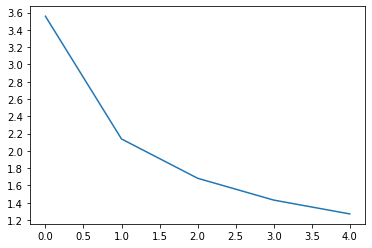

In [202]:
show_plot(epoch_losses)

## Inference

Inference is very similar to Seq2Seq models forward pass. However, here we are only interested in getting the output of one "sentence" or "phrase". We need to be consistent with our training when inputting. Hence, we are going to add SOS & EOS tokens to the input.

Unlike the training, we are keeping the attention values so that later we can create the attention map visualizations.

In [203]:
@torch.no_grad()
def infer(model: Seq2Seq, sentence: str, max_len: int):
    sentence = ' '.join([sos_token, normalize_string(sentence), eos_token])
    input_tensor = tensor_from_sentence(input_lang, sentence)
    padded_input_tensor = torch.full([longest_input_length], pad_token_index, dtype=torch.long, device=device)
    padded_input_tensor[:len(input_tensor)] = input_tensor
    encoder_output, hidden = model.encoder(padded_input_tensor.view(1, -1))
    decoder_attentions = torch.zeros(max_len, longest_input_length, device=device)
    decoded_words = []
    output = torch.tensor([sos_token_index], dtype=torch.long, device=device)
    for t in range(max_len):
        output, hidden, decoder_attention = model.decoder.forward(output, hidden, encoder_output)
        decoder_attentions[t] = decoder_attention[0, :]
        top_v, top_i = output.topk(1)
        top_i = top_i.squeeze(1)
        if top_i == eos_token_index:
            decoded_words.append(eos_token)
            break
        else:
            decoded_words.append(output_lang.index2word[top_i.item()])
        output = top_i.detach()

    return decoded_words, decoder_attentions

Function for random inference. We can cross check from google translate :) to test our model by our eyes.

In [204]:
def infer_randomly(model, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = infer(model, pair[0], longest_output_length)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [205]:
infer_randomly(model)

> he saw the girl .
= il a vu la fille .
< il a vu la fille . <end>

> i just wanted to check my email .
= je voulais juste verifier mes courriels .
< je voulais juste verifier mon emails . <end>

> who owns this house ?
= qui est proprietaire de cette maison ?
< qui a proprietaire cette maison ? <end>

> she is aggressive .
= elle est agressive .
< elle est agressive . <end>

> it was an awful week .
= ca a ete une semaine atroce .
< c etait une une semaine atroce . <end>



Visualizing raw attention map for a random pair.

['tom hates being told to hurry .', 'tom deteste qu on lui dise de se depecher .']
['tom', 'deteste', 'etre', 'il', 'a', 'a', 'depecher', '.', '<end>']


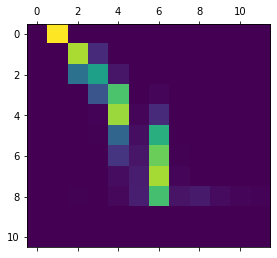

In [206]:
test_pair = random.choice(pairs)
print(test_pair)
decoded_words, decoder_attentions = infer(model, test_pair[0], longest_output_length)
print(decoded_words)
plt.matshow(decoder_attentions.cpu().numpy())

Prettifying our attention map to label indices and labels.

In [222]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [223]:
def infer_and_show_attention(input_sentence):
    output_words, attentions = infer(model, input_sentence, longest_output_length)
    output = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output)
    attentions = attentions[:len(output.split(' ')), 1:len(input_sentence.split(' ')) + 1]
    show_attention(' '.join([ normalize_string(input_sentence), eos_token]), output_words, attentions)

input = she s five years younger than me .
output = elle a cinq ans de jeune que moi . <end>


/tmp/ipykernel_11060/3299921217.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
/tmp/ipykernel_11060/3299921217.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


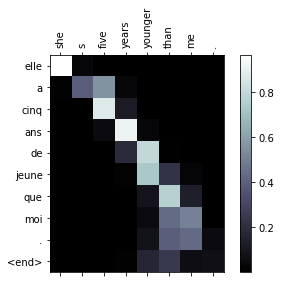

In [226]:
infer_and_show_attention('she s five years younger than me .')

## Optional Homeworks
- Using BLEU score to evaluate our models translation abilities.
- Train the model with different hyperparameters
- Try to use the same architecture with different dataset, Q/A, Chat/Response, Human/Machine(e.g. IOT commands)
- Try to use different models for encoder - decoder
    - try it with different attention mechanisms
    - try it without attention and compare results
- Training as an autoencoder
- After training try to use encoder as a backbone for other downstreams tasks, such emotion recognition.
- Instead of training embedding layer from scratch use pretrained embeddings such as word2vec - GloVe

sources:
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
- https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html
- https://sh-tsang.medium.com/review-neural-machine-translation-by-jointly-learning-to-align-and-translate-3b381fc032e3
- https://arxiv.org/pdf/1409.0473.pdf
- https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
- https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://github.com/SethHWeidman/pytorch-seq2seq/